## HDAT 9910 Capstone


Research Question 1: Mortality Prediction in ICU 

Task: The task is to build a predictive algorithm using the techniques we learned in this course. 

Objective: To assess the role of machine learning algorithms for predicting mortality by using the MIMIC-III dataset. 

Question: Is it possible to accurately predict mortality based on data from the first 24 hours in ICU?   

Study Population: MIMIC-III dataset 

#### Load packages


In [130]:
import numpy as np
import pandas as pd
import warnings
import os
import concurrent.futures
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)


#### Load in the preprocessed MIMIC-III Dataset

In [131]:
df = pd.read_csv('/Users\lukac\OneDrive\Desktop\HDAT-9910-Capstone/df_24Hrs.csv')

In [110]:
# Check the balance of the target variable
total_icu_stays = df['icustay_id'].nunique()
survivors = df.loc[df['mortality'] == 0, 'icustay_id'].nunique()
non_survivors = df.loc[df['mortality'] == 1, 'icustay_id'].nunique()

print(f"Number of ICU stays: {total_icu_stays}")
print(f"Number of survivors: {survivors}")
print(f"Number of non-survivors: {non_survivors}")

mortality_rate = (non_survivors / total_icu_stays) * 100
print(f"Mortality: {mortality_rate:.1f}%")

Number of ICU stays: 51366
Number of survivors: 28427
Number of non-survivors: 22939
Mortality: 44.7%


In [109]:
# Drop rows with any missing values
df.dropna(inplace=True)

### Model selection and training

In [111]:
from sklearn.model_selection import train_test_split

#Split the data into features and target variable
X = df.drop('mortality', axis=1)
y = df['mortality']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [112]:
from sklearn.preprocessing import StandardScaler

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Logistic Regression

In [113]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Hyperparameter tuning with GridSearchCV
parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(LogisticRegression(max_iter=1000), parameters, cv=5)
grid_search.fit(X_train_scaled, y_train)

best_model = grid_search.best_estimator_

In [114]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

# Making predictions with the best model
y_pred_log_reg = best_model.predict(X_test_scaled)
y_proba_log_reg = best_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_log_reg)
precision = precision_score(y_test, y_pred_log_reg)
recall = recall_score(y_test, y_pred_log_reg)
roc_auc = roc_auc_score(y_test, y_proba_log_reg)

# Print out the metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"ROC-AUC Score: {roc_auc:.2f}")


Accuracy: 0.75
Precision: 0.73
Recall: 0.70
ROC-AUC Score: 0.82


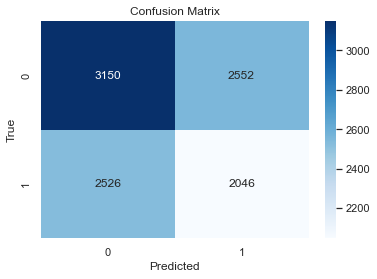

In [115]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Random Forest

In [119]:
from sklearn.ensemble import RandomForestClassifier

# Fit the model
forest = RandomForestClassifier()
forest.fit(X_train_scaled, y_train)

# Hyperperameter tuning
# Get important features
importances = forest.feature_importances_

# Select features based on importance
indices = np.argsort(importances)[::-1]

# Select a subset of the most important features
X_train_forest = X_train_scaled[:, indices[:300]]
X_test_forest = X_test_scaled[:, indices[:200]]

# Train a new model on the reduced set of features
forest.fit(X_train_forest, y_train)

RandomForestClassifier()

In [120]:
# Making predictions
y_pred_rf = forest.predict(X_test_forest)
y_proba_rf  = forest.predict_proba(X_test_forest)[:, 1] 

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_rf )
precision = precision_score(y_test, y_pred_rf )
recall = recall_score(y_test, y_pred_rf )
roc_auc = roc_auc_score(y_test, y_proba_rf)

# Print out the metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"ROC-AUC Score: {roc_auc:.2f}")


Accuracy: 0.74
Precision: 0.72
Recall: 0.70
ROC-AUC Score: 0.82


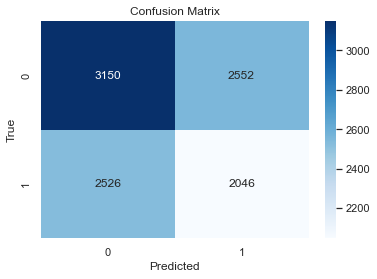

In [121]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Display a confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Decision trees

In [122]:
# Initialise the Decision Tree Classifier with the best parameters
dt = DecisionTreeClassifier(max_depth=5, min_samples_leaf=1, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(dt, X_train, y_train, cv=5, scoring='roc_auc')

print(f'Cross-Validation ROC-AUC Scores: {cv_scores}')
print(f'Mean ROC-AUC Score: {cv_scores.mean()}')

# Fit the model on the training data
dt.fit(X_train, y_train)


Cross-Validation ROC-AUC Scores: [0.76280634 0.75763732 0.76464173 0.76387763 0.76762571]
Mean ROC-AUC Score: 0.763317747136204


DecisionTreeClassifier(max_depth=5, random_state=42)

In [123]:
# Making predictions
y_pred_dt  = dt.predict(X_test)
y_proba_dt  = dt.predict_proba(X_test)[:, 1] 

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_dt )
precision = precision_score(y_test, y_pred_dt )
recall = recall_score(y_test, y_pred_dt )
roc_auc = roc_auc_score(y_test, y_proba_dt )

# Print out the metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"ROC-AUC Score: {roc_auc:.2f}")


Accuracy: 0.70
Precision: 0.66
Recall: 0.68
ROC-AUC Score: 0.77


### Neural networks

In [124]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


# Initialise the model
nn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_auc', patience=3, mode='max', restore_best_weights=True)

# Fit the model
nn_model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/10
1028/1028 [==============================] - 9s 3ms/step - loss: 0.5448 - auc: 0.8001 - val_loss: 0.5152 - val_auc: 0.8221
Epoch 2/10
1028/1028 [==============================] - 4s 4ms/step - loss: 0.5004 - auc: 0.8330 - val_loss: 0.5132 - val_auc: 0.8252
Epoch 3/10
1028/1028 [==============================] - 2s 2ms/step - loss: 0.4825 - auc: 0.8456 - val_loss: 0.5085 - val_auc: 0.8291
Epoch 4/10
1028/1028 [==============================] - 2s 2ms/step - loss: 0.4689 - auc: 0.8551 - val_loss: 0.5076 - val_auc: 0.8315
Epoch 5/10
1028/1028 [==============================] - 2s 2ms/step - loss: 0.4514 - auc: 0.8665 - val_loss: 0.5136 - val_auc: 0.8307
Epoch 6/10
1028/1028 [==============================] - 2s 2ms/step - loss: 0.4366 - auc: 0.8755 - val_loss: 0.5160 - val_auc: 0.8324
Epoch 7/10
1028/1028 [==============================] - 2s 2ms/step - loss: 0.4194 - auc: 0.8860 - val_loss: 0.5263 - val_auc: 0.8305
Epoch 8/10
1028/1028 [==============================] - 2s 2ms

In [125]:
# Making predictions
y_pred_nn = nn_model.predict(X_test_scaled) > 0.5
y_proba_nn = nn_model.predict(X_test_scaled)

# Calculate metrics
accuracy_nn = accuracy_score(y_test, y_pred_nn)
precision_nn = precision_score(y_test, y_pred_nn)
recall_nn = recall_score(y_test, y_pred_nn)
roc_auc_nn = roc_auc_score(y_test, y_proba_nn)

# Print out the metrics
print(f"Neural Network Accuracy: {accuracy_nn:.2f}")
print(f"Neural Network Precision: {precision_nn:.2f}")
print(f"Neural Network Recall: {recall_nn:.2f}")
print(f"Neural Network ROC-AUC Score: {roc_auc_nn:.2f}")

322/322 [==============================] - 1s 2ms/step
Neural Network Accuracy: 0.75
Neural Network Precision: 0.71
Neural Network Recall: 0.71
Neural Network ROC-AUC Score: 0.82


## Evaluating and Comparing Models

In [126]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# List to store results
results = []

# Function to evaluate model and append results
def evaluate_model(name, y_true, y_pred, y_proba):
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred),
        'ROC-AUC': roc_auc_score(y_true, y_proba)
    })

# Evaluate each model
evaluate_model('Logistic Regression', y_test, y_pred_log_reg, y_proba_log_reg)
evaluate_model('RandomForest', y_test, y_pred_rf, y_proba_rf)
evaluate_model('Decision Tree', y_test, y_pred_dt, y_proba_dt)
evaluate_model('Neural Networks', y_test, y_pred_nn, y_proba_nn)

# Convert results to DataFrame for display
results_df = pd.DataFrame(results)
print(results_df)


                 Model  Accuracy  Precision    Recall  F1 Score   ROC-AUC
0  Logistic Regression  0.748102   0.726277  0.696413  0.711032  0.822831
1         RandomForest  0.744306   0.720272  0.695538  0.707689  0.819577
2        Decision Tree  0.703718   0.663178  0.679134  0.671061  0.765539
3      Neural Networks  0.745085   0.713443  0.713911  0.713677  0.824564


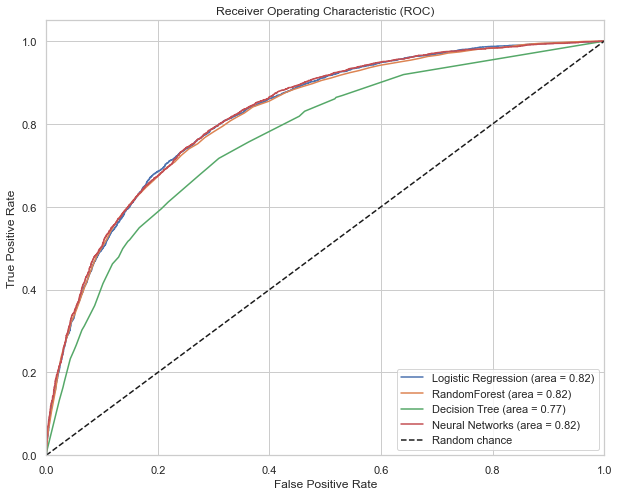

In [127]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 8))

# Function to plot ROC Curve
def plot_roc_curve(model_name, y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (area = {roc_auc:.2f})')

# Plot ROC Curve for each model
plot_roc_curve('Logistic Regression', y_test, y_proba_log_reg)
plot_roc_curve('RandomForest', y_test, y_proba_rf)
plot_roc_curve('Decision Tree', y_test, y_proba_dt)
plot_roc_curve('Neural Networks', y_test, y_proba_nn)

plt.plot([0, 1], [0, 1], 'k--', label='Random chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")

# Show plot
plt.show()



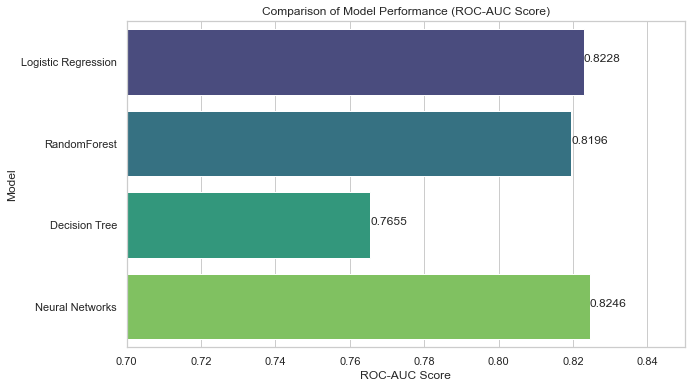

In [129]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data preparation
models = ['Logistic Regression', 'RandomForest', 'Decision Tree', 'Neural Networks']
roc_auc_scores = [0.822831, 0.819577, 0.765539, 0.824564]

# Visualisation
plt.figure(figsize=(10, 6))
sns.barplot(x=roc_auc_scores, y=models, palette='viridis')

plt.title('Comparison of Model Performance (ROC-AUC Score)')
plt.xlabel('ROC-AUC Score')
plt.ylabel('Model')

# Add the score labels on each bar
for index, value in enumerate(roc_auc_scores):
    plt.text(value, index, str(round(value, 4)))

plt.xlim(0.7, 0.85)  # Set limits to zoom in on differences
plt.show()
